In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import LegacySimulators
from qiskit.tools.visualization._bloch import Bloch
from qiskit.tools.visualization._circuit_visualization import circuit_drawer
from qiskit_aqua.algorithms import AmplitudeEstimation
from qiskit_aqua.components.uncertainty_problems import UncertaintyProblem
from qiskit_aqua.algorithms.single_sample.ae.q_factory import QFactory
from qiskit_aqua.utils.circuit_utils import cry

# Amplitude Estimation
<br>
This notebook illustrates amplitude estimation in the simplest case, where the (assumed to be unkown) success probability $p$ of a Bernoulli random variable is estimated.
In other words, we assume a qubit is prepared in a state $\sqrt{1-p}\,\big|0\rangle + \sqrt{p}\,\big|1\rangle$, i.e., the probability of measuring $\big|1\rangle$ equals $p$.
This matches the results that have been demonstrated on real hardware in [1].
<br>
<br>
Amplitude estimation uses two operators: $A$ and $Q$, where $A$ describes the problem and $Q$ is derived from $A$ [2].
Here, $A = R_y(\theta_p)$, i.e., it equals a rotation with an angle $\theta_p = 2\sin^{-1}(\sqrt{p})$ around the Y-axis. For this single qubit case, $Q$ can  be represented by a Y-rotation around twice that angle, i.e., $Q = R_y(2\theta_p)$ [1]. 
This particularly implies that powers of the operator can be efficiently represented, i.e. $Q^k = R_y(2k\theta_p)$.
The result is then mapped into $m$ evaluation qubits. The larger $m$, the higher the accuracy of the estimation but also the longer the quantum circuit.
<br>
<br>
[1] <a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>
<br>
[2] <a href="https://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Brassard et al. 2000.</a>

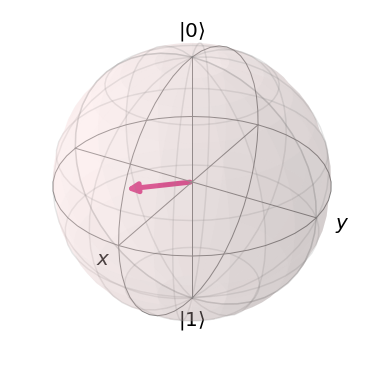

In [2]:
# the probability to be recovered
probability = 0.3
theta_p = 2*np.arcsin(np.sqrt(probability))

# the resulting quantum state after A is applied
bloch = Bloch()
bloch.add_vectors([np.sin(theta_p), 0.0, np.cos(theta_p)])
bloch.show()

In [3]:
class BernoulliAFactory(UncertaintyProblem):
    """
    Circuit Factory representing the operator A.
    A is used to initialize the state as well as to construct Q.
    """
    
    def __init__(self, probability=0.5, i_state=None):
        super().__init__(1)
        self._probability = probability
        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        if i_state is None:
            i_state = 0
        self._params = {'i_state': i_state}
    
    def build(self, qc, q, q_ancillas=None, params=None):
        if params is None:
            params = self._params
        # A is a rotation of angle theta_p around the Y-axis
        qc.ry(self._theta_p, q[params['i_state']])


class BernoulliQFactory(QFactory):
    """
    Circuit Factory representing the operator Q.
    This implementation exploits the fact that powers of Q can be implemented efficiently by just multiplying the angle.
    (amplitude estimation only requires controlled powers of Q, thus, only this method is overridden.)
    """
    
    def __init__(self, bernoulli_expected_value):
        super().__init__(bernoulli_expected_value)
    
    def build(self, qc, q, q_ancillas=None, params=None):
        i_state = self.a_factory._params['i_state']
        theta_p = self.a_factory._theta_p
        # Q is a rotation of angle 2*theta_p around the Y-axis
        qc.ry(q[i_state], 2*theta_p)
    
    def build_controlled_power(self, qc, q, q_control, power, q_ancillas=None, params=None):
        i_state = self.a_factory._params['i_state']
        theta_p = self.a_factory._theta_p
        cry(2*power*theta_p, q_control, q[i_state], qc)

In [4]:
# construct factories for A and Q
bernoulli_a_factory = BernoulliAFactory(probability)
bernoulli_q_factory = BernoulliQFactory(bernoulli_a_factory)

In [5]:
# set number of evaluation qubits
m = 3

# construct amplitude estimation
ae = AmplitudeEstimation(m, bernoulli_a_factory, q_factory=bernoulli_q_factory)

In [6]:
# result = ae.run(quantum_instance=LegacySimulators.get_backend('qasm_simulator'))
result = ae.run(quantum_instance=LegacySimulators.get_backend('statevector_simulator'))

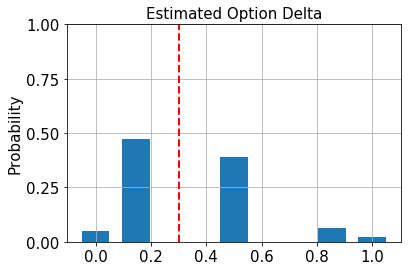

In [7]:
# plot estimated values for delta
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Delta', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

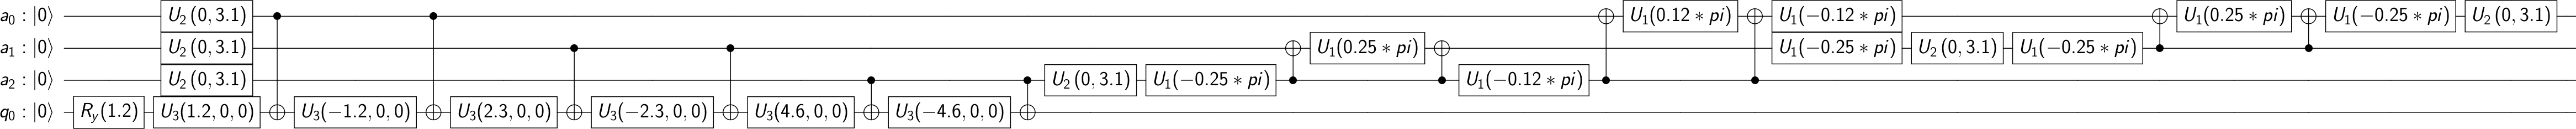

In [8]:
# plot circuit
circuit_drawer(ae._circuit, output='latex')